# Predicción de la Tasa de Abandono en Telecomunicaciones: Caso Interconnect

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

**Servicios de Interconnect**

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

**Descripción de los datos**

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Análisis Exploratorio y Limpieza

Vamos a hacer un poco de análisis exploratorio de los datos para familiarizarnos un poco con la estructura de los mismos y ver a qué nos vamos a enfrentar.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [2]:
contract_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/contract.csv')
personal_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/personal.csv')
internet_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/internet.csv')
phone_data = pd.read_csv('https://raw.githubusercontent.com/MrDonBromo/TripleTenDS-Final-Project/refs/heads/main/phone.csv')

### Contract Data

In [3]:
contract_data.info()
contract_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# Converting the type of data to datetime.

contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])

# Using format = %Y-%m-%d %H:%M:%S kept turning the whole column into NaT. We're replacing "No" with NaT first, then turning into datetime.

contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'].replace('No', pd.NaT),  errors='coerce')

contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
# Theres 'TotalCharges' with ' '. Why could that be?

print('Contracts with no total charges:\n\n',contract_data[contract_data['TotalCharges'] == ' '][['customerID','BeginDate']])
print('\nMost recent date in the dataframe:',sorted(contract_data['BeginDate'].unique())[-1])

Contracts with no total charges:

       customerID  BeginDate
488   4472-LVYGI 2020-02-01
753   3115-CZMZD 2020-02-01
936   5709-LVOEQ 2020-02-01
1082  4367-NUYAO 2020-02-01
1340  1371-DWPAZ 2020-02-01
3331  7644-OMVMY 2020-02-01
3826  3213-VVOLG 2020-02-01
4380  2520-SGTTA 2020-02-01
5218  2923-ARZLG 2020-02-01
6670  4075-WKNIU 2020-02-01
6754  2775-SEFEE 2020-02-01

Most recent date in the dataframe: 2020-02-01 00:00:00


All contracts with no total charges on them have begin dates of 2020-02-01, which coincidentally is the latest date on the dataset. That's probably because these users haven't been charged yet and their contracts are new.

In [6]:
# We're converting the column to a number and filling out nulls with 0.

contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'],errors='coerce')

contract_data['TotalCharges'] = contract_data['TotalCharges'].fillna(0)

print(contract_data.info())

contract_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


We're leaving end date NULLs as is. We'll use them to create the Churn target column.

In [7]:
# Create the Churn column and fill with 0 if there is no contract end date, 1 if there is, which means the contract churned.

contract_data['Churn'] = np.where(contract_data['EndDate'].isna(), 0, 1)
display(contract_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Changing Paperless Billing from Yes and No to binary. 1 for Yes, 0 for No.

In [8]:
contract_data['PaperlessBilling'] = contract_data['PaperlessBilling'].map({'Yes':1, 'No':0})
display(contract_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


In [9]:
# We'll verify for consistency printing the unique values of each column and see if it makes sense.

for column in contract_data.columns:
    print(column, contract_data[column].nunique())

customerID 7043
BeginDate 77
EndDate 4
Type 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6531
Churn 2


We'll change the type of data on Type and PaymentMethod to categoric. This will help later on when training our prediction models.

In [10]:
contract_data['Type'] = contract_data['Type'].astype('category')
contract_data['PaymentMethod'] = contract_data['PaymentMethod'].astype('category')

contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
dtypes: category(2), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 399.4+ KB


### Personal Data

In [11]:
personal_data.info()
personal_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Let's see if there are duplicated customer IDs.

In [12]:
if personal_data['customerID'].is_unique:
    print('There are no duplicated customerIDs')
else:
    print('There are duplicated customerIDs')

There are no duplicated customerIDs


We'll turn the Partner and Dependents columns into binary. SeniorCitizen was binary already.

In [13]:
personal_data['Partner'] = personal_data['Partner'].map({'Yes':1, 'No':0})
personal_data['Dependents'] = personal_data['Dependents'].map({'Yes':1, 'No':0})
display(personal_data.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


In [14]:
#Quickly check if the amount of unique values is consistent.

for column in personal_data.columns:
    print(column, personal_data[column].nunique())

customerID 7043
gender 2
SeniorCitizen 2
Partner 2
Dependents 2


In [15]:
# We'll turn gender into a category type of data. Could be binary, but I'd rather leave it as category and deal with it later.

personal_data['gender'] = personal_data['gender'].astype('category')
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   int64   
 3   Partner        7043 non-null   int64   
 4   Dependents     7043 non-null   int64   
dtypes: category(1), int64(3), object(1)
memory usage: 227.2+ KB


### Internet Data

In [16]:
internet_data.info()
internet_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


We'll change all Yes and No from applicable columns into binary values.

In [17]:
internet_data_columns = internet_data.columns
internet_data_columns = internet_data_columns[2:]

for column in internet_data_columns:
    internet_data[column] = internet_data[column].map({'Yes':1, 'No':0})

display(internet_data.head())


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [18]:
#Checking uniques per column for consistency

for column in internet_data.columns:
    print(column, internet_data[column].nunique())

customerID 5517
InternetService 2
OnlineSecurity 2
OnlineBackup 2
DeviceProtection 2
TechSupport 2
StreamingTV 2
StreamingMovies 2


In [19]:
#Changing the one column that we're missing into categoric.

internet_data['InternetService'] = internet_data['InternetService'].astype('category')

internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5517 non-null   object  
 1   InternetService   5517 non-null   category
 2   OnlineSecurity    5517 non-null   int64   
 3   OnlineBackup      5517 non-null   int64   
 4   DeviceProtection  5517 non-null   int64   
 5   TechSupport       5517 non-null   int64   
 6   StreamingTV       5517 non-null   int64   
 7   StreamingMovies   5517 non-null   int64   
dtypes: category(1), int64(6), object(1)
memory usage: 307.3+ KB


### Phone Data

In [20]:
phone_data.info()
print(phone_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


In [21]:
# Changing the only column from this dataframe into 0 and 1.

phone_data['MultipleLines'] = phone_data['MultipleLines'].map({'Yes':1, 'No':0})
display(phone_data.head())

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


In [22]:
# Checking for duplicates

print('Contract duplicates:',contract_data[contract_data.duplicated()])
print('Personal Data duplicates:',personal_data[personal_data.duplicated()])
print('Internet duplicates:',internet_data[internet_data.duplicated()])
print('Phone duplicates:',phone_data[phone_data.duplicated()])

Contract duplicates: Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []
Personal Data duplicates: Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents]
Index: []
Internet duplicates: Empty DataFrame
Columns: [customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies]
Index: []
Phone duplicates: Empty DataFrame
Columns: [customerID, MultipleLines]
Index: []


We have successfully imported all the different CSV files. Some, like the internet and phone data, do not have 7,043 entries, which suggests that there are customers who do not have internet service, or alternatively, do not have phone service. At first glance, we can see that there are more customers with phone contracts than with internet contracts.

It can also be observed that no duplicates were found in any of the dataframes. In the case of the contracts, there are 11 that do not have total charges, and their dates are all the same — 2020/02/01 — which likely means their billing date has not yet passed, so the system has not recorded them yet. These have been replaced with 0. Out of the 7,043 contracts in the record, only 1,869 have a contract termination date, meaning that around 5,000 contracts are still active. These will be left as null, so that a calculated column for terminated contracts, 'Churn', can be created.

###  Visualización

Text(0.5, 1.0, 'Count of Contracts per Type of Service')

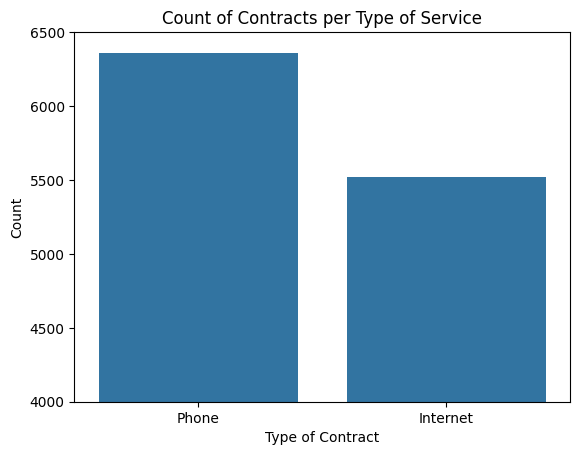

In [23]:
count_users = pd.DataFrame({'User':['Phone', 'Internet'],
                           'Count':[phone_data.shape[0], internet_data.shape[0]]})

sns.barplot(data=count_users, x='User', y='Count',)
plt.ylim(4000, 6500)
plt.xlabel('Type of Contract')
plt.title('Count of Contracts per Type of Service')

Text(0.5, 1.0, 'New Contracts per Year')

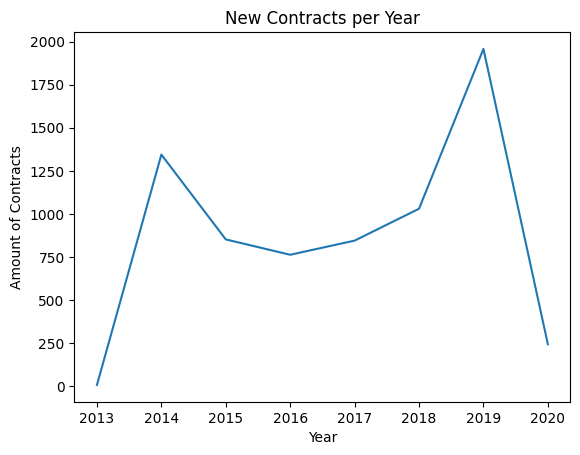

In [24]:
new_contracts_py = contract_data.groupby(contract_data['BeginDate'].dt.year).size()

sns.lineplot(data=new_contracts_py)
plt.xlabel('Year')
plt.ylabel('Amount of Contracts')
plt.title('New Contracts per Year')

gender
Female    3488
Male      3555
dtype: int64


<ipython-input-25-61c6b15a4c8e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_gender = personal_data.groupby('gender').size()


(3400.0, 3600.0)

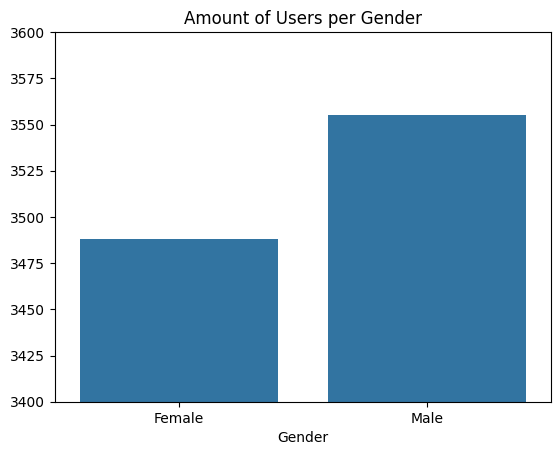

In [25]:
size_gender = personal_data.groupby('gender').size()

print(size_gender)

sns.barplot(data=size_gender)
plt.title('Amount of Users per Gender')
plt.xlabel('Gender')
plt.ylim(3400,3600)

No hay mucha diferencia entre ambos géneros, sólo 100 personas aprox. más hombres que mujeres.

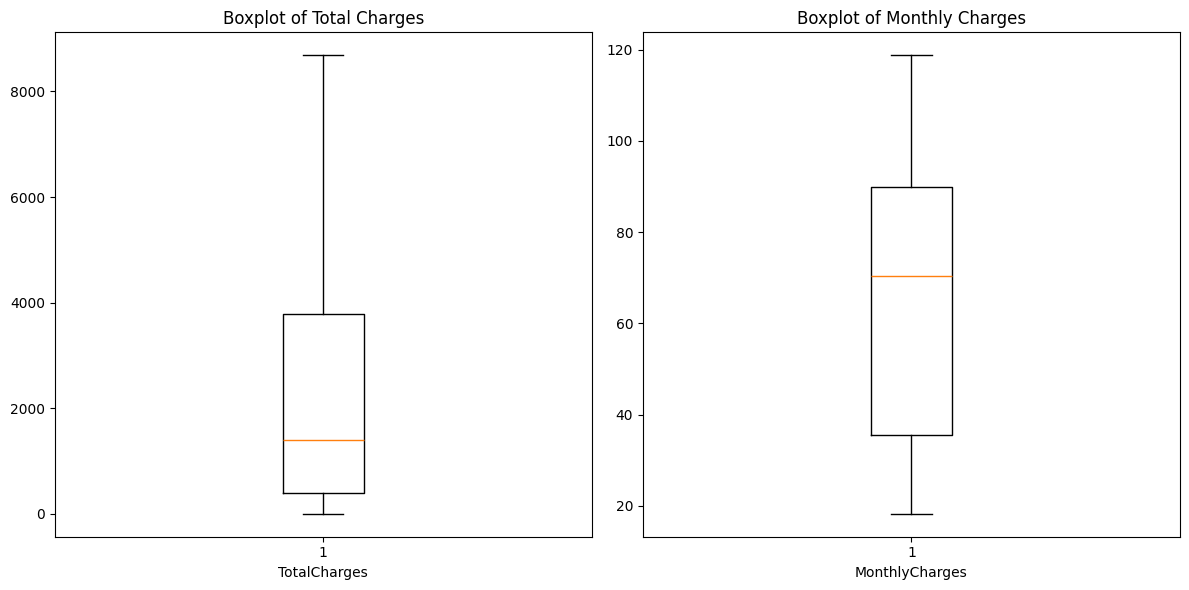

In [26]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].boxplot(contract_data['TotalCharges'])
axs[0].set_title('Boxplot of Total Charges')
axs[0].set_xlabel('TotalCharges')

axs[1].boxplot(contract_data['MonthlyCharges'])
axs[1].set_title('Boxplot of Monthly Charges')
axs[1].set_xlabel('MonthlyCharges')

plt.tight_layout()

Text(0.5, 1.0, 'Distribution of Total Charges by Churn')

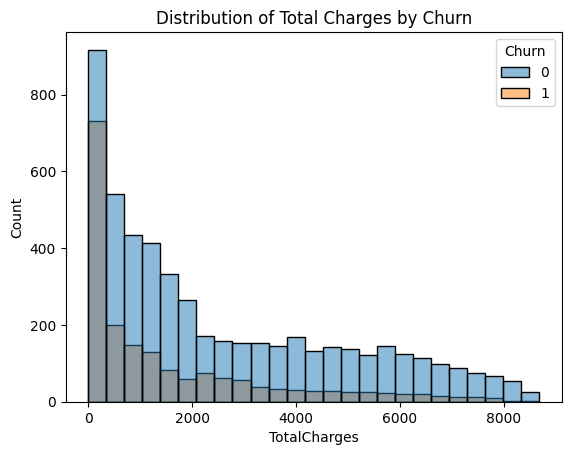

In [27]:
sns.histplot(data=contract_data, x='TotalCharges', hue='Churn')
plt.title('Distribution of Total Charges by Churn')

Text(0.5, 1.0, 'Churned Contracts per Year')

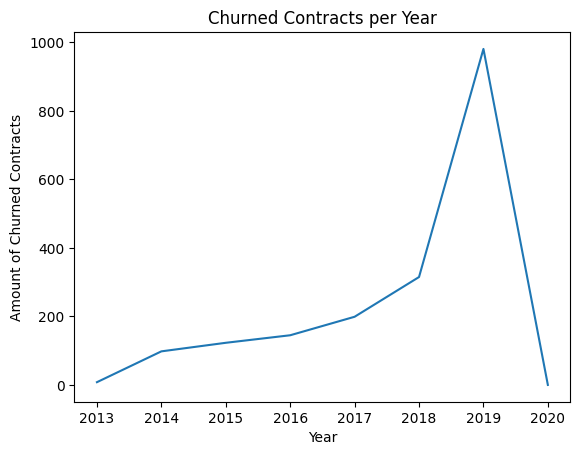

In [29]:
churn_over_time = contract_data.groupby(contract_data['BeginDate'].dt.year).agg({'Churn':'sum'})

sns.lineplot(data=churn_over_time, x=churn_over_time.index, y='Churn')
plt.xlabel('Year')
plt.ylabel('Amount of Churned Contracts')
plt.title('Churned Contracts per Year')

It seems there's been an increase in churned contracts per year.

In [74]:
print('Descriptive Stats of MonthlyCharges:\n',contract_data['MonthlyCharges'].describe())
print('\nDescriptive Stats of TotalCharges:\n',contract_data['TotalCharges'].describe())

Descriptive Stats of MonthlyCharges:
 count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Descriptive Stats of TotalCharges:
 count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


In [92]:
print(contract_data['Churn'].value_counts(normalize=True)*100)

Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


Aproximadamente el 73% de los datos son ejemplos de contratos que fueron rescindidos "Churned", y el otro 27% son aquellos que sí fueron rescindidos. Por esto, haremos un ejercicio de sobremuestreo para poder entrenar nuestro modelo con mejores datos. Compararemos el performance del modelo usando métricos como F1 y área debajo de la curva, y compararemos modelos que puedan manejar desbalanceo como XGBoost.

Parece que no hay outliers identificados en las columnas de cargos totales ni mensuales según los boxplot. Cargos totales tiene sus datos muy cargados hacia la izquierda, con la mitad de los datos estando entre la mitad de sus datos entre 0 y 1394, y el resto de 1394 a 8684. Esto puede significar que sólo hay algunos clientes con cuentas "viejas", ya que la columna de cargos totales es la suma de todo lo que se ha pagado durante el contrato, y entre más tiempo a pasado, más dinero se ha generado de este contrato. También se verá afectado por los servicios que tiene contratado, claro. Por ejemplo, alguien que tiene su contrato desde enero 2020 va a tener su cargo total igual a su cargo mensual, ya que el corte de estos datos es a febrero 2020.

Cargos mensuales parecen estar más distribuidos al rededor de la mediana. De igual forma, no se encontraron outliers.

## Plan de Trabajo

Se ha identificado el desbalanceo de clases en la columna objetivo Churn. En las siguientes partes del proyecto revisaremos como taclear esto con sobremuestreo. También podríamos ajustar hiperparámetros dentro de los mismos modelos, como en bosque aleatorio, donde podemos ajustar los pesos con class_weight='balanced'.


A través de ingeniería de características trabajaremos para realizar un dataframe maestro con las caracteristicas que más nos interesan, como lo son los datos personales, el tipo de contrato, las formas de pago, etc. Para esto estaremos haciendo una serie de joins entre los dataframes para tener todo en uno solo y poder generar nuestro modelo predictivo. Habiendo tenido nuestra tabla maestra, podemos ir descartanto columnas que no nos sean de utilidad, o calcular nuevas, como 'Churn' que nos indique si el contrato fue rescindido o no, y esta columna sería nuestra función objetivo en el modelo. Se probarán distintos tipos de modelaje de clasificación binaria para tratar de llegar a un métrico F1 adecuado usando técnicas como one hot encoding y potenciación.


<b>Organización</b> 🗂️

<pre>
## Fase 1: Análisis Exploratorio
- Verificación de duplicados, nulos, tipos de datos
- Visualizaciones iniciales

## Fase 2: Ingeniería y Limpieza
- Conversión de variables, imputación
- Creación de columna 'Churn'
- Revisión del balance de clases

## Fase 3: Selección de Características
- Análisis de correlación / uso de Boruta, SHAP o métodos de filtrado
- Reducción de dimensionalidad si aplica

## Fase 4: Ingeniería de Características
- One hot encoding, escalamiento, creación de nuevas columnas

## Fase 5: Modelado
- Pruebas con diferentes algoritmos de clasificación binaria
- Evaluación con métricas: F1, ROC AUC, precisión, recall

## Fase 6: Interpretación y Conclusión
- Interpretación del modelo
- Recomendaciones para el equipo de marketing
</pre>



## Selección e Ingeniería de Características



### Merging de Tablas
Vamos a unir todas las tablas para consolidarlas en una sola, teniendo como llave principal el customerID.

In [ ]:
df_merged = contract_data.merge(personal_data, on='customerID', how='left')

In [ ]:
df_merged = df_merged.merge(internet_data, on='customerID',how='left')

In [ ]:
df_merged = df_merged.merge(phone_data, on='customerID',how='left')

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   int64         
 12  Dependents        7043 non-null   int64         
 13  InternetService   5517 non-null   category      
 14  OnlineSecurity    5517 n

Hemos juntado todas las tablas en una sola. Tenemos 21 columnas, de las cuales eligiremos las de mayor relevancia para predecir nuestro objetivo "Churn". Se hizo un join "izquierda" para identificar a todos los clientes, incluso los que no tienen servicios de internet, o no tienen línea telefónica, y se pueden identificar como los null. De los 7043 contratos, se identificaron aprox 4000 que tienen ambos servicios. Lo bueno aquí es que todos los clientes tienen sus datos personales. Vamos a manejar los null en la siguiente parte.

In [ ]:
df_merged['InternetService'] = df_merged['InternetService'].cat.add_categories(['No Service'])
df_merged['InternetService'].fillna('No Service', inplace=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   int64         
 12  Dependents        7043 non-null   int64         
 13  InternetService   7043 non-null   category      
 14  OnlineSecurity    5517 n

In [ ]:
# Donde 0 representa que no tiene el servicio para las caracteristicas relacionadas con internet. Todos los "no service" deben tener estas columnas en 0.

columns = df_merged.columns[14:]

for column in columns:
    df_merged[column] = df_merged[column].fillna(0).astype('int')

df_merged.info()

### Elección de Features

Con esto ya tenemos nuestra base de datos consolidada y limpia. Vamos a eliminar las columnas que no sean de relevancia para predecir si un cliente rescinde su contrato o no. Eligiremos apriori las columnas que no tendrán relevancia, como genero, customerID, begindate y enddate.

In [ ]:
df_merged_filtered = df_merged.drop(['customerID','BeginDate','EndDate','gender'],axis=1)

#### One Hot Encoding

In [ ]:
#Ya que estamos manejando un objetivo categórico, no hay riesgo de multicolinearidad

categorical_columns = ['Type','PaymentMethod','InternetService']

df_encoded = pd.get_dummies(df_merged_filtered,columns=categorical_columns)

display(df_encoded.head())

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No Service
0,1,29.85,29.85,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0
1,0,56.95,1889.50,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,1,0,0
2,1,53.85,108.15,1,0,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0
3,0,42.30,1840.75,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,1,0,0
4,1,70.70,151.65,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


#### Correlación con Churn

Vamos a utilizar la correlación de las columnas con Churn para elegir las más importantes. Se definirá como aquellas mayores de 0.1 absoluto. Para ejercicios posteriores se podría considerar utilizar correlación biserial puntual en vez de corr() ya que puede ser más adhoc al objetivo (binario).

In [ ]:
correlation = df_encoded.corr()['Churn'].sort_values(ascending=False)
print(correlation)

Churn                                      1.000000
Type_Month-to-month                        0.405103
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
StreamingTV                                0.063228
StreamingMovies                            0.061382
MultipleLines                              0.040102
DeviceProtection                          -0.066160
OnlineBackup                              -0.082255
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
InternetService_DSL                       -0.124214
PaymentMethod_Credit card (automatic)     -0.134302
Partner                                   -0.150448
Dependents                                -0.164221
TechSupport                               -0.164674
OnlineSecuri

In [ ]:
high_corr_columns = []

for column in correlation.index:
    if abs(correlation[column]) > 0.1:
        high_corr_columns.append(column)

print(high_corr_columns)

['Churn', 'Type_Month-to-month', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'MonthlyCharges', 'PaperlessBilling', 'SeniorCitizen', 'PaymentMethod_Bank transfer (automatic)', 'InternetService_DSL', 'PaymentMethod_Credit card (automatic)', 'Partner', 'Dependents', 'TechSupport', 'OnlineSecurity', 'Type_One year', 'TotalCharges', 'InternetService_No Service', 'Type_Two year']


In [ ]:
df_encoded_filtered = df_encoded[high_corr_columns]

print(df_encoded_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Churn                                    7043 non-null   int64  
 1   Type_Month-to-month                      7043 non-null   uint8  
 2   InternetService_Fiber optic              7043 non-null   uint8  
 3   PaymentMethod_Electronic check           7043 non-null   uint8  
 4   MonthlyCharges                           7043 non-null   float64
 5   PaperlessBilling                         7043 non-null   int64  
 6   SeniorCitizen                            7043 non-null   int64  
 7   PaymentMethod_Bank transfer (automatic)  7043 non-null   uint8  
 8   InternetService_DSL                      7043 non-null   uint8  
 9   PaymentMethod_Credit card (automatic)    7043 non-null   uint8  
 10  Partner                                  7043 no

#### Balanceo de Clases

Vamos a incrementar la cantidad de filas donde churn es 1 para aproximar a 50:50. Utilizaremos SMOTE para rebalancear las clases con sobremuestreo aleatorio.

In [ ]:
pip install --user imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from imblearn.over_sampling import SMOTE

features = df_encoded_filtered.drop('Churn',axis=1)
target = df_encoded_filtered['Churn']

smote = SMOTE(random_state=12345)
features_resampled, target_resampled = smote.fit_resample(features,target)

df_resampled = pd.DataFrame(features_resampled, columns=features.columns)
df_resampled['Churn'] = target_resampled

print(df_resampled['Churn'].value_counts())

0    5174
1    5174
Name: Churn, dtype: int64


#### Escalado de MonthlyCharges y TotalCharges
Vamos a escalar los datos continuos de cargos mensuales y totales para acercarlos a 1 y 0 y evitar que el modelo le de mucho peso.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_resampled[['MonthlyCharges','TotalCharges']] = scaler.fit_transform(df_resampled[['MonthlyCharges','TotalCharges']])

df_resampled.head()

,Type_Month-to-month,InternetService_Fiber optic,PaymentMethod_Electronic check,MonthlyCharges,PaperlessBilling,SeniorCitizen,PaymentMethod_Bank transfer (automatic),InternetService_DSL,PaymentMethod_Credit card (automatic),Partner,Dependents,TechSupport,OnlineSecurity,Type_One year,TotalCharges,InternetService_No Service,Type_Two year,Churn
0,1,0,1,-1.326002,1,0,0,1,0,1,0,0,0,0,-0.922351,0,0,0
1,0,0,0,-0.379446,0,0,0,1,0,0,0,0,1,1,-0.067506,0,0,0
2,1,0,0,-0.487724,1,0,0,1,0,0,0,0,1,0,-0.886358,0,0,1
3,0,0,0,-0.891145,0,0,1,1,0,0,0,1,1,1,-0.089916,0,0,0
4,1,1,1,0.100818,1,0,0,0,0,0,0,0,0,0,-0.866362,0,0,1


## Modelado

Con nuestras clases balanceadas, caracteristicas con OHE, filtradas por correlación mayor a 0.1 y catacterísticas continuas escaladas, podemos empezar a modelar y a evaluar las predicciones, para luego modificar y mejorar.

### Separación de Datos de Entrenamiento y Validación

Vamos a separar 80% del dataframe para entrenamiento y 20% para validación.

In [ ]:
features = df_resampled.drop('Churn',axis=1)
target = df_resampled['Churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

### RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=12345)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(features_train, target_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
target_predict = best_model.predict(features_test)

target_probs = best_model.predict_proba(features_test)[:, 1]

print('Mejores parámetros:',best_params)
print(classification_report(target_test, target_predict))

Mejores parámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1007
           1       0.84      0.84      0.84      1063

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



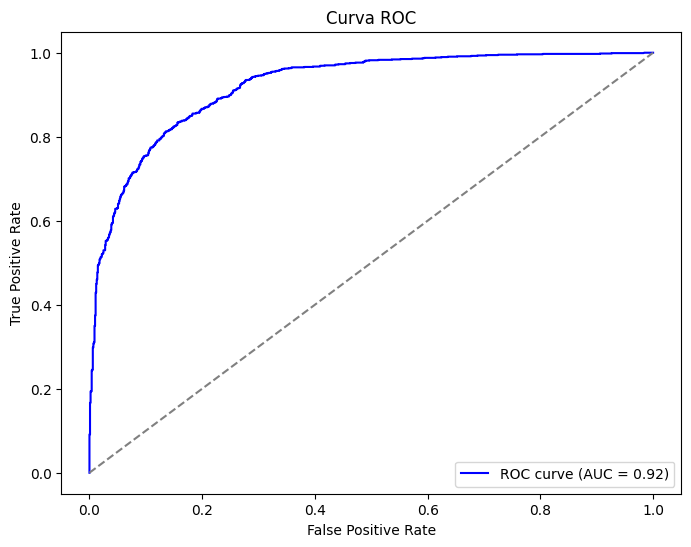

In [ ]:
fpr, tpr, _ = roc_curve(target_test, target_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### LogisticRegressor

In [ ]:
model_lr = LogisticRegression(solver='liblinear',random_state=12345, max_iter = 10000)

model_lr.fit(features_train, target_train)

target_predict_lr = model_lr.predict(features_test)

In [ ]:
print(classification_report(target_test,target_predict_lr))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1007
           1       0.82      0.84      0.83      1063

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



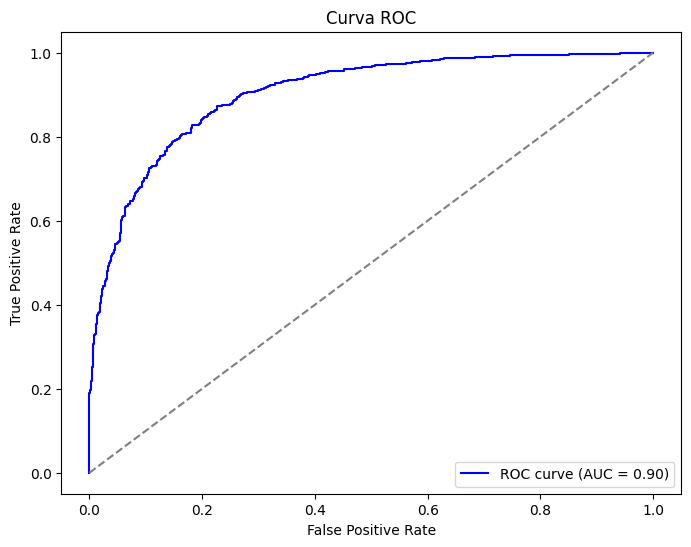

In [ ]:
target_probs = model_lr.predict_proba(features_test)[:, 1]
fpr, tpr, _ = roc_curve(target_test, target_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(features_train, target_train)
target_predict_xgb = model_xgb.predict(features_test)

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:39:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
print(classification_report(target_test,target_predict_xgb))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1007
           1       0.84      0.84      0.84      1063

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



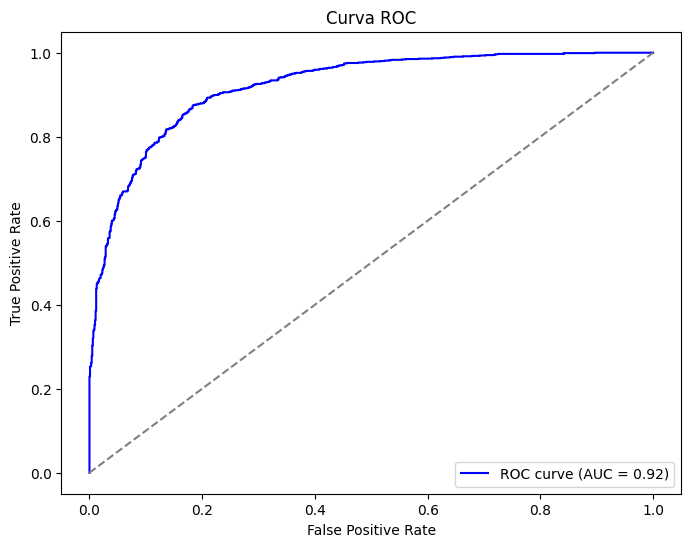

In [ ]:
target_probs = model_xgb.predict_proba(features_test)[:, 1]
fpr, tpr, _ = roc_curve(target_test, target_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Conclusiones

En este proyecto se desarrolló un modelo predictivo con el objetivo de identificar a los clientes de Interconnect que tienen mayor probabilidad de cancelar su contrato. Para lograrlo, se siguió un proceso estructurado que incluyó varias etapas clave.

Primero, se importaron cuatro conjuntos de datos con información relevante: datos personales, uso de internet, detalles de contrato y registros de telefonía. A continuación, se realizó una limpieza detallada de los datos, completando valores faltantes, revisando posibles inconsistencias y generando la variable objetivo "churn".

Una vez limpia la información, se llevó a cabo un análisis exploratorio para entender mejor el comportamiento de los clientes. Se utilizaron gráficos y estadísticas descriptivas para detectar patrones y tendencias. Posteriormente, se unificaron los cuatro dataframes en una sola base consolidada, lo que permitió analizar la correlación entre variables y determinar cuáles estaban más relacionadas con la cancelación del servicio.

Dado que la variable "churn" presentaba un desbalance en las clases, se aplicaron técnicas para equilibrar la proporción de clientes que cancelaron vs. los que no, buscando una distribución más equitativa (50:50). Además, se transformaron las variables categóricas mediante one hot encoding y se escalaron aquellas que no eran binarias, asegurando que todas estuvieran en un formato adecuado para el entrenamiento.

Se probaron tres modelos de clasificación: XGBoost, Random Forest y Regresión Logística. Entre ellos, XGBoost fue el que mostró el mejor desempeño, alcanzando un valor F1 de 0.84, lo que lo posiciona como el modelo más preciso en la predicción de clientes propensos a cancelar.

Gracias a este modelo, Interconnect ahora cuenta con una herramienta poderosa para anticiparse a la pérdida de clientes, permitiendo implementar estrategias de retención más efectivas y mejorar la experiencia general del usuario.


## Informe de solución

### ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?


Se realizaron las siguientes acciones en el desarrollo del proyecto:
- Fase 1: Verificación de duplicados, valores nulos y tipos de datos, seguida de visualizaciones iniciales para comprender la distribución de los datos.
- Fase 2: Conversión de variables, creación de la columna Churn y revisión del balanceo de clases.
- Fase 3: Análisis de correlación para identificar relaciones entre variables. Se eliminaron columnas de bajo valor según los resultados obtenidos y se llevó a cabo la fusión (merge) de las cuatro bases de datos.
- Fase 4: Transformación mediante One-Hot Encoding, escalamiento de datos y balanceo de clases con SMOTE.
- Fase 5: Modelado utilizando XGBoost, regresión logística y RandomForestClassifier. Evaluación de modelos con métricas clave: F1, Recall, Accuracy y curvas ROC AUC.
- Fase 6: Elaboración de recomendaciones y comentarios finales sobre el desempeño de los modelos.

Ningún paso en específico fue omitido.


### ¿Qué dificultades encontraste y cómo lograste resolverlas?

Se presentó un poco de problema el tema del desbalanceo de clases, ya que al rededor de 25% eran 1 en Churn y 75% eran 0. Esto se resolvió usando SMOTE para generar entradas sintéticas de la clase de menor frecuencia y que nuestros modelos no se vean afectados. También se trabajó escalando los cargos totales y mensuales para que no fueran a afectar mucho los pesos de los modelos.

### ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

Fue clave la generación de la columna Churn, nuestro objetivo. A priori no estaba incluido en los dataframes, así que crearla era básico para tener un objetivo para nuestros modelos. Clave también fue hacer joins de todos las bases de datos y poder tener un dataframe completo con todos nuestros features. Lo demás es cuestión de limpieza y balanceo, también importantes, sin embargo sin una columna objetivo, no habría un modelo que entrenar en primer lugar.

### ¿Cuál es tu modelo final y qué nivel de calidad tiene?

Eligiría XGBoost ya que obtuvo los mejores números en los métricos F1, precisión y recall, 0.84 y AUC ROC de 0.92. Es muy buen modelo al tener alto rendimiento y velocidad, maneja automáticamente valores nulos, e incorpora regularización L1 y L2.

# Comentario general del revisor